# Aprendizaje automático relacional

#### Fernando Jesús Fernández Gallardo
#### Carmen Galván López

## Preparación

#### Imports y variables globales

In [103]:
import pandas
import numpy as np
import sklearn
import networkx as nx
from sklearn import preprocessing, model_selection, naive_bayes, neighbors
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from scipy import stats

semilla = 86

#### Lectura y procesamiento inicial de los datos brutos

In [104]:
#Leemos los archivos
vertices = pandas.read_csv('data/political-books-nodes.csv')
aristas = pandas.read_csv('data/political-books-edges.csv')

#Borramos la columna ID
del(vertices['Id'])

#Mostramos las primeras 35 filas
vertices.head(35)

,Label,political_ideology
0,1000 Years for Revenge,neutral
1,Bush vs. the Beltway,conservative
2,Charlie Wilson's War,conservative
3,Losing Bin Laden,conservative
4,Sleeping With the Devil,neutral
5,The Man Who Warned America,conservative
6,Why America Slept,neutral
7,Ghost Wars,neutral
8,A National Party No More,conservative
9,Bush Country,conservative


#### Selección y validación de los datos brutos

In [105]:
"""
Comprobamos que el dataset es válido verificando que no existen duplicados
"""
if len(vertices) != len(set(vertices['Label'])):
    raise ValueError("El dataset no es válido ya que contiene duplicados")
"""
La mejor forma de identificar cada uno de los elementos que forma parte
del conjunto de entrenamiento es el nombre del propio libro (que en el dataset
se llama 'Label') en vez del ID o cualquier otro tipo de indentificador más
complejo. De esta forma, también es más fácil identificar elementos duplicados
(si los hubiera)
"""
atributos = vertices['Label']
"""
Nuestro objetivo es predecir la ideología política del autor basándonos en
sus obras, por lo que el objetivo que perseguimos en nuestro modelo
es el de la ideología política
"""
objetivos = vertices['political_ideology']

## Inicio del entrenamiento
#### Codificación del objetivo

In [106]:

"""
Para poder trabajar con los datos que tenemos, necesitamos convertirlos en un formato que sklearn pueda "entender".
Debemos de hacer que nuestros datos "planos" sean para sklearn objetos "comparables", dependiendo del tipo de
ordenación que nosotros veamos más apropiada para el método en cuestión
(de una manera similar hacemos en Java cuando implementamos la interfaz 'Comparable' y el método compareTo)

El codificador adecuado para la variable objetivo es LabelEncoder, que trabaja
con una lista o array unidimensional de sus valores y admite cadenas

"""
# Codificadores
codificador_atributos = preprocessing.LabelEncoder()
codificador_objetivos = preprocessing.LabelEncoder()
# Datos codificados
atributos_codificados = codificador_atributos.fit_transform(atributos)
objetivos_codificados = codificador_objetivos.fit_transform(objetivos)

#### División en conjunto de entrenamiento y conjunto de prueba

Partimos el atributo y el objetivo en dos, de entrenamiento y de prueba

In [107]:
(atributos_entrenamiento,
 atributos_prueba,
 objetivos_entrenamiento,
 objetivos_prueba) = model_selection.train_test_split(
        atributos_codificados,
        objetivos_codificados,
        # Valor de la semilla aleatoria para que el muestreo sea reproducible a pesar de ser aleatorio
        random_state=semilla,
        test_size=.33,
        stratify=objetivos_codificados
)

#Creamos nuevos ejemplos para futuras operaciones
nuevos_ejemplos = [[1.], [20.], [2.]]

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

## KNN no relacional

In [108]:
def encontrar_mejor_k(atributos, objetivo, k_range, cv=5):
    puntajes_por_k = []

    # Convertir los atributos en un array bidimensional con una sola columna
    atributos = np.array(atributos).reshape(-1, 1)

    for k in k_range:
        # Crear clasificador KNN con el valor actual de k
        knn = KNeighborsClassifier(n_neighbors=k)

        # Suprimir los warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            # Realizar validación cruzada y obtener los puntajes
            puntajes = cross_val_score(knn, atributos, objetivo, cv=cv, scoring='accuracy')

        # Calcular el puntaje medio de validación cruzada
        puntaje_medio = puntajes.mean()

        # Almacenar el puntaje correspondiente al valor de k
        puntajes_por_k.append((k, puntaje_medio))

    return puntajes_por_k

encontrar_mejor_k(atributos_codificados, objetivos_codificados, k_range=list(range(1, 20)), cv=5)

[(1, 0.2761904761904762),
 (2, 0.3333333333333333),
 (3, 0.3142857142857143),
 (4, 0.3142857142857142),
 (5, 0.2952380952380952),
 (6, 0.3333333333333333),
 (7, 0.3142857142857143),
 (8, 0.3238095238095238),
 (9, 0.36190476190476184),
 (10, 0.35238095238095235),
 (11, 0.3619047619047619),
 (12, 0.3904761904761904),
 (13, 0.3904761904761905),
 (14, 0.36190476190476184),
 (15, 0.4095238095238095),
 (16, 0.3714285714285714),
 (17, 0.42857142857142855),
 (18, 0.39047619047619053),
 (19, 0.3904761904761904)]

In [109]:
# Convertir los atributos y objetivos en arrays bidimensionales
atributos_entrenamiento_2d = np.array(atributos_entrenamiento).reshape(-1, 1)
atributos_prueba_2d = np.array(atributos_prueba).reshape(-1, 1)
objetivos_entrenamiento_2d = np.array(objetivos_entrenamiento).reshape(-1, 1)
objetivos_prueba_2d = np.array(objetivos_prueba).reshape(-1, 1)

#Según el k_scores, podemos ver que a partir de 10 vecinos es totalmente irrelevante cuantos pongamos, 
#así que utilizaremos n_neighbors=10,
#Definimos y entrenamos kNN

clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors=10, metric='hamming')

clasif_kNN.fit(atributos_entrenamiento_2d, objetivos_entrenamiento)

# Probamos la predicción con los atributos de prueba
print('Predicción kNN:', clasif_kNN.predict(atributos_prueba_2d))

# Hacemos el score con kNN
print('Precisión kNN:', clasif_kNN.score(atributos_prueba_2d, objetivos_prueba_2d))

# Hacemos el score con cross validation utilizando los datos de entrenamiento
cv_scores = cross_val_score(clasif_kNN, atributos_entrenamiento_2d, objetivos_entrenamiento, cv=cv)
print('Precisión cross validation:', np.mean(cv_scores))

Predicción kNN: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Precisión kNN: 0.4857142857142857
Precisión cross validation: 0.4428571428571428


In [110]:
#Vamos a dar algunos datos sobre knn como pueden ser la distancia, los vecinos más cercanos a un dato, 
#y las clases de esos vecinos

distancias, vecinos = clasif_kNN.kneighbors(nuevos_ejemplos)
print("Primer ejemplo nuevo:", nuevos_ejemplos[0])
print("10 vecinos más cercanos:")
print([vecinos[0]])
print("Distancias a esos vecinos (cantidad de atributos con valores distintos / cantidad total de atributos):")
print(distancias[0])  
def obtenerClases(vecinos):
    l=[]
    for index in vecinos[0]:
        l.append(objetivos[index])
    return l
print("Clases a las que pertenecen esos vecinos: ", obtenerClases(vecinos))

Primer ejemplo nuevo: [1.0]
10 vecinos más cercanos:
[array([27, 58,  5, 64, 49,  4, 68,  0, 50, 48], dtype=int64)]
Distancias a esos vecinos (cantidad de atributos con valores distintos / cantidad total de atributos):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Clases a las que pertenecen esos vecinos:  ['conservative', 'conservative', 'conservative', 'liberal', 'conservative', 'neutral', 'liberal', 'neutral', 'conservative', 'neutral']


## Sacar métricas relacionales

In [112]:
# Cargar el grafo desde el archivo
df = pandas.read_csv('data/political-books-edges.csv')
grafo = nx.from_pandas_edgelist(df, 'Source', 'Target')

#### Degree centrality.

Métrica relacionada con la centralidad. El número de conexiones (enlaces) que tiene ese nodo. Los nodos con mayor grado se consideran más centrales en términos de conectividad.

In [113]:
def obtenerDegreeCentrality(grafo):
    centrality = nx.degree_centrality(grafo)
    return list(centrality.values())

# Obtener la lista de Degree Centrality
degree_centrality = obtenerDegreeCentrality(grafo)

vertices['Degree_Centrality'] = degree_centrality
vertices.head(25)

,Label,political_ideology,Degree_Centrality
0,1000 Years for Revenge,neutral,0.038462
1,Bush vs. the Beltway,conservative,0.057692
2,Charlie Wilson's War,conservative,0.038462
3,Losing Bin Laden,conservative,0.221154
4,Sleeping With the Devil,neutral,0.076923
5,The Man Who Warned America,conservative,0.067308
6,Why America Slept,neutral,0.105769
7,Ghost Wars,neutral,0.076923
8,A National Party No More,conservative,0.240385
9,Bush Country,conservative,0.153846


#### High closeness centrality.

Métrica relacionada con la centralidad. Si un nodo tiene un mayor grado, significa que está conectado a un mayor número de otros nodos en el grafo.

In [114]:
def calcularHighClosenessCentrality(grafo):
    high_closeness = nx.closeness_centrality(grafo, u=None, distance=None, wf_improved=True)
    return list(high_closeness.values())

# Calcular el high closeness centrality
high_closeness = calcularHighClosenessCentrality(grafo)

vertices['High_closeness_centrality'] = high_closeness
vertices.head(25)

,Label,political_ideology,Degree_Centrality,High_closeness_centrality
0,1000 Years for Revenge,neutral,0.038462,0.303207
1,Bush vs. the Beltway,conservative,0.057692,0.345515
2,Charlie Wilson's War,conservative,0.038462,0.309524
3,Losing Bin Laden,conservative,0.221154,0.371429
4,Sleeping With the Devil,neutral,0.076923,0.390977
5,The Man Who Warned America,conservative,0.067308,0.356164
6,Why America Slept,neutral,0.105769,0.379562
7,Ghost Wars,neutral,0.076923,0.407843
8,A National Party No More,conservative,0.240385,0.378182
9,Bush Country,conservative,0.153846,0.406250


#### High betweenness centrality.

Métrica relacionada con la centralidad. Un nodo con un alto valor de "high betweenness centrality" actúa como un puente o un punto de conexión crucial entre diferentes partes del grafo.

In [115]:
def calcularHighBetweennessCentrality(grafo):
    betweenness = nx.betweenness_centrality(grafo, normalized=True, endpoints=False)
    return list(betweenness.values())

# Calcular el high betweenness centrality
high_betweenness = calcularHighBetweennessCentrality(grafo)

vertices['High_betweenness_centrality'] = high_betweenness
vertices.head(25)

,Label,political_ideology,Degree_Centrality,High_closeness_centrality,High_betweenness_centrality
0,1000 Years for Revenge,neutral,0.038462,0.303207,0.000049
1,Bush vs. the Beltway,conservative,0.057692,0.345515,0.007433
2,Charlie Wilson's War,conservative,0.038462,0.309524,0.000521
3,Losing Bin Laden,conservative,0.221154,0.371429,0.076093
4,Sleeping With the Devil,neutral,0.076923,0.390977,0.062928
5,The Man Who Warned America,conservative,0.067308,0.356164,0.012881
6,Why America Slept,neutral,0.105769,0.379562,0.056297
7,Ghost Wars,neutral,0.076923,0.407843,0.068724
8,A National Party No More,conservative,0.240385,0.378182,0.074908
9,Bush Country,conservative,0.153846,0.406250,0.098395


#### Coeficiente de clustering.

Es una medida que cuantifica qué tan conectados están los vecinos de un nodo en comparación con todas las posibles conexiones entre ellos.

In [116]:
def obtenerCoeficienteClustering(grafo):
    # Obtener el coeficiente de clustering para cada vértice
    coeficientes = nx.clustering(grafo)
    return list(coeficientes.values())

# Obtener la lista de coeficientes de clustering
coeficientes_clustering = obtenerCoeficienteClustering(grafo)

vertices['Clustering'] = coeficientes_clustering
vertices.head(25)

,Label,political_ideology,Degree_Centrality,High_closeness_centrality,High_betweenness_centrality,Clustering
0,1000 Years for Revenge,neutral,0.038462,0.303207,0.000049,0.833333
1,Bush vs. the Beltway,conservative,0.057692,0.345515,0.007433,0.600000
2,Charlie Wilson's War,conservative,0.038462,0.309524,0.000521,0.666667
3,Losing Bin Laden,conservative,0.221154,0.371429,0.076093,0.209486
4,Sleeping With the Devil,neutral,0.076923,0.390977,0.062928,0.250000
5,The Man Who Warned America,conservative,0.067308,0.356164,0.012881,0.523810
6,Why America Slept,neutral,0.105769,0.379562,0.056297,0.181818
7,Ghost Wars,neutral,0.076923,0.407843,0.068724,0.178571
8,A National Party No More,conservative,0.240385,0.378182,0.074908,0.253333
9,Bush Country,conservative,0.153846,0.406250,0.098395,0.300000


#### Modularidad.

Métrica relacionada con la detección de comunidades. Si un nodo tiene un mayor grado, significa que está conectado a un mayor número de otros nodos en el grafo.

In [101]:
def calcularModularidad(grafo):
    particion = nx.community.greedy_modularity_communities(grafo)
    modularidad = nx.community.modularity(grafo, particion)
    return modularidad

# Calcular la modularidad
modularidad = calcularModularidad(grafo)

# Imprimir la modularidad
print(modularidad)

0.5019744859395006


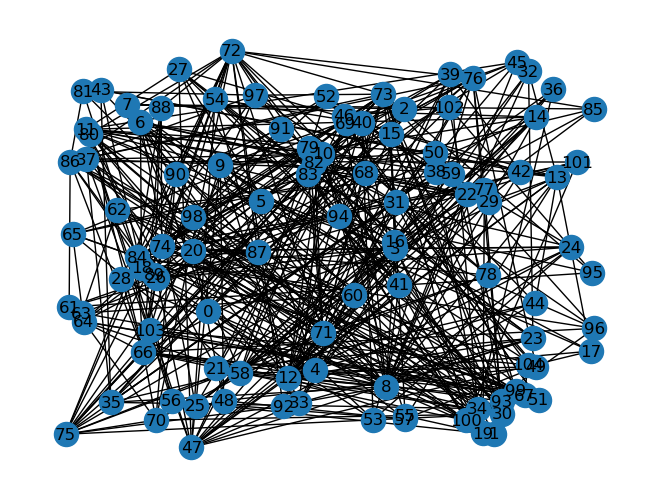

In [102]:
G = nx.read_graphml('data/political-books-network.graphml')
nx.draw_random(G, with_labels=True)